# Imports & Dependencies
- Package Requirements: pandas, numpy, matplotlib, shap, scikit-learn
- Additional files: collinearity_check.py & kennard_stone.py

In [18]:
# Basic Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

#Scikit-learn Dependencies
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# External Python Files
import kennard_stone as ks 
from collinearity_check import assess_collinearity
from linear_rfe_svm import perform_grid_search_cv  # SVC function

# Set the random seed for reproducibility
random_state = 42  

# Have Some Fun With Your Plot Settings
font = {'family': 'Avenir Next', 'weight': 'normal', 'size': 16}
plt.rc('font', **font)

# Data Preparation
- Fill out the following cell to load data. Requests a single header row.
- Optional Visualization of Data Distribution (Histogram)
- Optional Binarizing of Continuous Data (Manual Threshold)
- Pairwise Collinearity Filtering of Features


In [2]:
excel_file = "Example.xlsx" # Excel name as string
sheet_name = "Model" # sheet with training data and features
index_name = 'Index' # numerical column

n_features = 190 # number of independent variables
feature_start_col = 2 # zero-indexed
output_column = 'Average_R2R3' #string value for output column
output_binary = False # boolean for whether the output is binary. False = continuous

# Load Excel spreadsheet as DataFrame
data = pd.read_excel(excel_file, sheet_name=sheet_name, index_col=index_name)

# Define features and output variables
X = data.iloc[:, feature_start_col:n_features+feature_start_col]
if output_binary == True:
    y_binary = data[output_column]
else:
    y_cont = data[output_column]

display(data.head())

,kraken_id,Average_R2R3,vmin_vmin_boltz,vmin_r_boltz,fmo_e_homo_boltz,fmo_e_lumo_boltz,fmo_mu_boltz,fmo_eta_boltz,fmo_omega_boltz,somo_ra_boltz,...,sterimol_burB5_boltz,sterimol_burB5_min,sterimol_burB5_max,sterimol_burB5_delta,sterimol_burB5_vburminconf,sterimol_burL_boltz,sterimol_burL_min,sterimol_burL_max,sterimol_burL_delta,sterimol_burL_vburminconf
Index,,,,,,,,,,,,,,,,,,,,,
0,2014,0.0,-0.075848,1.822230,-0.208145,-0.028543,-0.118344,0.179602,0.038990,0.050703,...,7.051159,6.796484,7.684267,0.887783,6.966066,7.107802,7.032582,7.719974,0.687392,7.480646
1,2032,0.0,-0.070351,1.830065,-0.211892,-0.049081,-0.130486,0.162811,0.052314,0.033953,...,7.188534,6.969260,7.705582,0.736322,7.038297,7.115989,7.002841,7.339487,0.336646,7.101796
2,39,5.8,-0.065696,1.830797,-0.214109,-0.037421,-0.125765,0.176688,0.044763,0.046666,...,6.959986,6.910482,7.031886,0.121404,7.031886,6.898491,6.727968,7.351934,0.623966,7.269082
3,31,0.0,-0.062160,1.782107,-0.225350,-0.025040,-0.125195,0.200310,0.039124,0.080490,...,6.029335,6.029335,6.029335,0.000000,6.029335,7.042766,7.042766,7.042766,0.000000,7.042766
4,12,0.2,-0.062406,1.780166,-0.221080,0.028890,-0.096095,0.249970,0.018471,0.106560,...,6.198222,6.198222,6.198222,0.000000,6.198222,6.665977,6.665977,6.665977,0.000000,6.665977


## Histogram

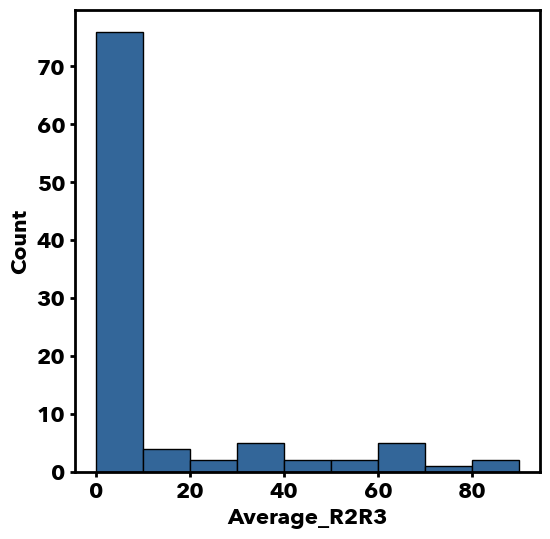

In [3]:
bin_color = '#336699' #change bin color to desired string value

plt.figure(figsize=(6, 6))
plt.hist(y_cont, bins=range(0, 100, 10), edgecolor='black',color=bin_color)
plt.xlabel(output_column)
plt.ylabel('Count')
plt.grid(False)

# Customize the plot borders and ticks
ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', width=2) 

#Optional: Save Figure to PNG
#plt.savefig('output_histogram.png', bbox_inches='tight',transparent='True')

#Show Figure
plt.show()

## Convert Continuous Data to Binary 
- Running this cell will not impact binary input data
- Only prompts input if inputting continuous data

In [4]:
# interactive threshold for binarizing continuous data
# y_binary only exists if boolean set to True
try:
    _ = y_binary
except NameError:
    user_threshold = float(input("Enter Threshold (% Yield, etc.):"))
    print('Binarizing Data Based on User Threshold Value...')
    y_binary = (y_cont > user_threshold).astype(int)
    y_binary_df = pd.Series.to_frame(y_binary)
    #display(y_binary_df)
else:
    print('Binary data already imported! Proceed with feature selection.')


Binarizing Data Based on User Threshold Value...


## Interactive Collinearity Cutoff
- simple pairwise collinearity threshold (Note: External file needed)
- Note: downstream SVM incorporates recursive feature elimination

In [5]:
#redefine x after removing independent variables with all constant values
X_no_const = X.loc[:, X.apply(pd.Series.nunique) > 1]

#enter threshold (interactive)
threshold = float(input("Enter the collinearity threshold (e.g., 0.7): "))
collinear_features = assess_collinearity(X_no_const, threshold)

#redfine x after dropping collinear features
X_nocolin = X_no_const.drop(columns=collinear_features)

#print shape of remaining dataframe
print("Shape of X_nocolin:", X_nocolin.shape)
display(X_nocolin.head())

Shape of X_nocolin: (99, 141)


,vmin_vmin_boltz,vmin_r_boltz,fmo_e_homo_boltz,fmo_e_lumo_boltz,fmo_mu_boltz,fmo_eta_boltz,somo_ra_boltz,somo_rc_boltz,nbo_P_boltz,nbo_P_ra_boltz,...,sterimol_burB5_boltz,sterimol_burB5_min,sterimol_burB5_max,sterimol_burB5_delta,sterimol_burB5_vburminconf,sterimol_burL_boltz,sterimol_burL_min,sterimol_burL_max,sterimol_burL_delta,sterimol_burL_vburminconf
Index,,,,,,,,,,,,,,,,,,,,,
0,-0.075848,1.822230,-0.208145,-0.028543,-0.118344,0.179602,0.050703,-0.348867,0.818007,0.772409,...,7.051159,6.796484,7.684267,0.887783,6.966066,7.107802,7.032582,7.719974,0.687392,7.480646
1,-0.070351,1.830065,-0.211892,-0.049081,-0.130486,0.162811,0.033953,-0.352418,0.808347,0.782050,...,7.188534,6.969260,7.705582,0.736322,7.038297,7.115989,7.002841,7.339487,0.336646,7.101796
2,-0.065696,1.830797,-0.214109,-0.037421,-0.125765,0.176688,0.046666,-0.361883,0.781730,0.769078,...,6.959986,6.910482,7.031886,0.121404,7.031886,6.898491,6.727968,7.351934,0.623966,7.269082
3,-0.062160,1.782107,-0.225350,-0.025040,-0.125195,0.200310,0.080490,-0.404680,0.765850,0.721410,...,6.029335,6.029335,6.029335,0.000000,6.029335,7.042766,7.042766,7.042766,0.000000,7.042766
4,-0.062406,1.780166,-0.221080,0.028890,-0.096095,0.249970,0.106560,-0.449980,0.751860,0.729910,...,6.198222,6.198222,6.198222,0.000000,6.198222,6.665977,6.665977,6.665977,0.000000,6.665977


## Training Test Split

In [6]:
# Perform train/test split (random)
test_ratio = 0.20 # in percent (e.g., 0.20 = 20% test, 80% train)
X_train, X_test, y_train, y_test = ks.train_test_split(X_nocolin, y_binary, test_size=test_ratio,random_state=random_state)

# Apply scaling to training set and transform test based on train mean and stddev
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Support Vector Classifier (Linear Kernel)

In [7]:
# Define the parameters for cross-validation & feature selection
k_fold = 5  #cross-validation during SVM training
steps = 1  #features removed at each step of RFE
c_values = [1]  # Common C values for regularization
param_grid_linear = {'svc__C': c_values} # Parameter grid for linear kernel

param_grids = {
    'linear': param_grid_linear,
}

selected_kernels = ['linear']
best_models = perform_grid_search_cv(selected_kernels, param_grids, X_train_scaled_df, y_train, X_test_scaled_df, y_test, random_state, steps, k_fold)

# Access the variables
best_pipeline = best_models['linear']['best_pipeline']
best_rfecv = best_models['linear']['best_rfecv']
best_svc_model = best_models['linear']['best_svc_model']
selected_features = best_models['linear']['selected_features']

print("Selected Features:", selected_features)

Running GridSearchCV for linear kernel...
Best Linear SVM Parameters: {'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Training Set Accuracy: 0.9746835443037974
Test Set Accuracy: 0.9
Cross-Validation Scores: [0.835]
Best Cross-Validation Score: 0.835
Number of Features Selected: 12

Cross-Validation Scores for Best Parameter Combination:
Fold 1: 0.875
Fold 2: 0.8125
Fold 3: 0.8125
Fold 4: 0.875
Fold 5: 0.8
Classification Report for Linear Kernel Training Set:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        62
           1       0.94      0.94      0.94        17

    accuracy                           0.97        79
   macro avg       0.96      0.96      0.96        79
weighted avg       0.97      0.97

## Confusion Matrices

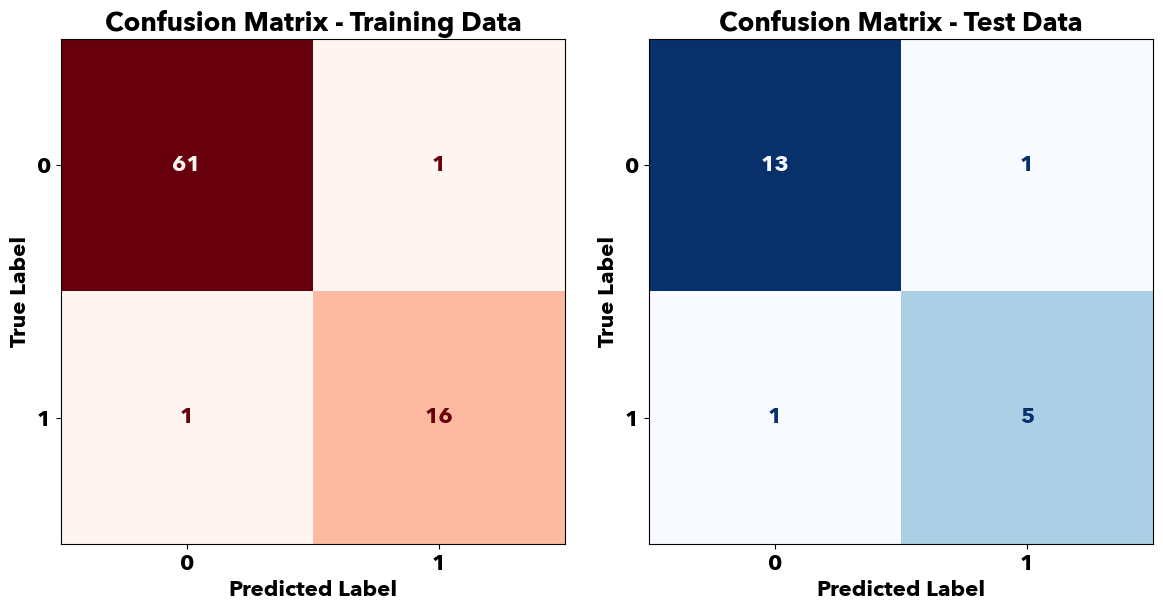

In [8]:
y_train_pred = best_pipeline.predict(X_train_scaled_df)
y_test_pred = best_pipeline.predict(X_test_scaled_df)

# Create the confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Create subplots for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the confusion matrix for training data
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot(ax=axes[0], cmap = 'Reds', colorbar=False)
axes[0].set_title("Confusion Matrix - Training Data")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Display the confusion matrix for test data
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(ax=axes[1], cmap = 'Blues', colorbar=False)
axes[1].set_title("Confusion Matrix - Test Data")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

# Adjust layout
plt.tight_layout()
plt.show()


## Model Equation

In [9]:
# Get the coefficients and intercept from the best SVC model

coefficients = best_svc_model.coef_[0]
intercept = best_svc_model.intercept_[0]

# Create the equation string
equation = "f(x) = "
for i, coef in enumerate(coefficients):
    equation += f"({coef:.2f} * {selected_features[i]}) + "
equation += f"({intercept:.2f})"

# Print the equation
print("SVM Equation:")
print(equation)


SVM Equation:
f(x) = (-0.71 * vmin_r_boltz) + (-0.60 * fmo_mu_boltz) + (0.90 * nbo_lp_P_occ_boltz) + (-0.90 * nbo_bd_occ_avg_boltz) + (-1.10 * fukui_p_boltz) + (-0.71 * dipolemoment_delta) + (0.62 * vbur_qvbur_max_boltz) + (0.69 * vbur_qvbur_max_max) + (-0.94 * vbur_ovtot_max_delta) + (0.95 * sterimol_B5_boltz) + (-0.69 * sterimol_L_min) + (-0.59 * sterimol_burB5_vburminconf) + (-2.29)


## Top Coefficients

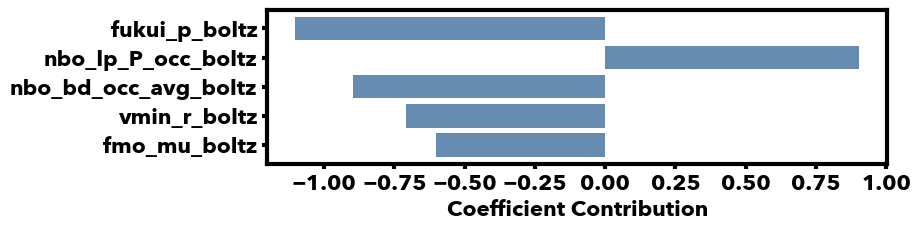

In [10]:
color = '#336699'  # Change to desired color
feature_importances = pd.DataFrame({
    'Feature': selected_features[0:5],
    'Coefficient': coefficients[0:5]
})

feature_importances['Absolute Coefficient'] = feature_importances['Coefficient'].abs()
feature_importances = feature_importances.sort_values(by='Absolute Coefficient', ascending=False)

# Plot the sorted coefficients
plt.figure(figsize=(8, 2))
plt.barh(feature_importances['Feature'], feature_importances['Coefficient'], color=color, alpha=0.75)
plt.xlabel('Coefficient Contribution')
plt.gca().invert_yaxis()

ax = plt.gca()
ax.spines['top'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.tick_params(axis='both', width=3)  # Make the ticks thicker

#plt.savefig('top_features.png', bbox_inches='tight', pad_inches=0.1, dpi=300) # Save the figure to a file
plt.show()

## Shap Analysis

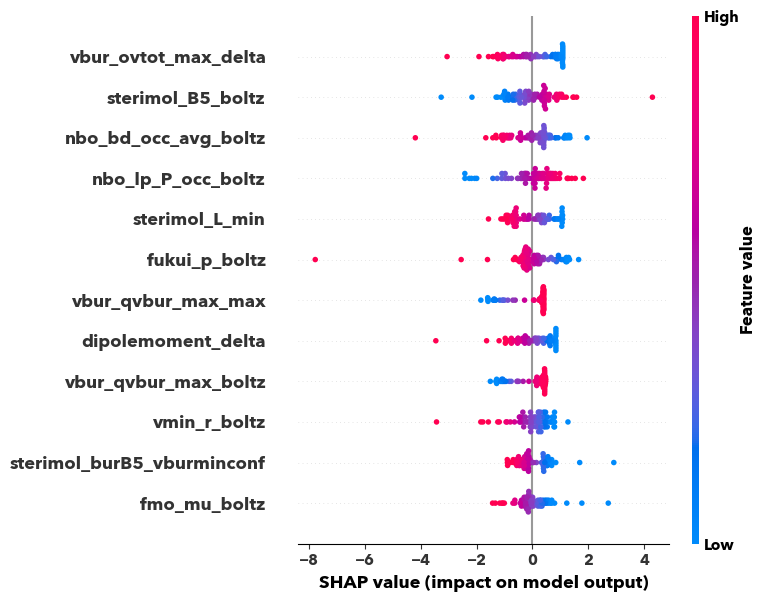

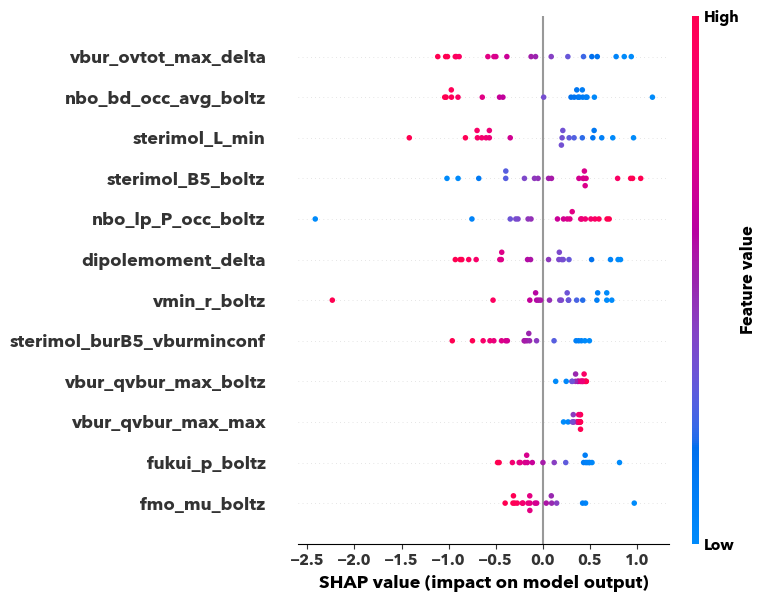

In [11]:
explainer = shap.Explainer(best_svc_model, X_train_scaled_df[selected_features])
shap_values_train = explainer.shap_values(X_train_scaled_df[selected_features])
shap_values_test = explainer.shap_values(X_test_scaled_df[selected_features])

# Plot the SHAP summary plots
shap.summary_plot(shap_values_train, X_train_scaled_df[selected_features], feature_names=selected_features)
shap.summary_plot(shap_values_test, X_test_scaled_df[selected_features], feature_names=selected_features)


# Model Visualization

## Generate dataframe for visualization and future saving of decision values

In [12]:
# Select the features from the training and test sets
X_train_selected = X_train_scaled_df[selected_features]
X_test_selected = X_test_scaled_df[selected_features]

# Compute decision values for the training and test sets
decision_values_train = best_svc_model.decision_function(X_train_selected.values)
decision_values_test = best_svc_model.decision_function(X_test_selected.values)

# Create DataFrames for decision values and Ligand IDs
decision_df_train = pd.DataFrame({
    'Decision Value': decision_values_train,
    'Split': 'Train',
    'True Class Label': y_train  # Assuming y_train contains true class labels
})

decision_df_test = pd.DataFrame({
    'Decision Value': decision_values_test,
    'Split': 'Test',
    'True Class Label': y_test  # Assuming y_test contains true class labels
})

# Concatenate the DataFrames
decision_combined_df = pd.concat([decision_df_train, decision_df_test])
decision_combined_df['kraken_id'] = data['kraken_id']
decision_combined_df[output_column] = data[output_column]

display(decision_combined_df)


,Decision Value,Split,True Class Label,kraken_id,Average_R2R3
Index,,,,,
59,-1.689805,Train,0,277,0.0
16,-0.999563,Train,0,2023,2.0
78,1.498271,Train,1,2027,89.5
29,-1.000106,Train,0,2040,1.0
57,-0.957925,Train,0,2024,0.0
...,...,...,...,...,...
41,-3.118727,Test,0,2046,0.0
63,3.144743,Test,1,276,87.5
93,-2.294737,Test,0,4,0.0


## Save the Decision Values to a Spreadsheet

In [13]:
#display(nonlinear_combined_df)
with pd.ExcelWriter('values_for_important_descriptors.xlsx') as excel_writer:
    decision_combined_df.to_excel(excel_writer, sheet_name='Linear')

# Display RFE SVM

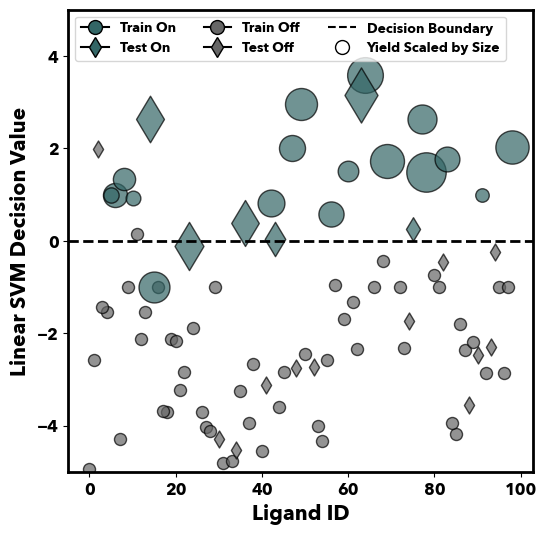

In [14]:
plt.figure(figsize=(6, 6))

# Define a minimum size for the symbols
min_symbol_size = 75
linear_y_min = -5
linear_y_max = 5

# Scatterplot for Linear SVM Data
for idx, row in decision_combined_df.iterrows():
    marker = 'o' if row['Split'] == 'Train' else 'd'
    edgecolors = 'black' if row['Split'] == 'Train' else 'black'
    color = '#666666' if row['True Class Label'] == 0 else '#336666'
    plt.scatter(idx, row['Decision Value'],
                c=color, s=np.maximum(row[output_column] * 9, min_symbol_size),
                marker=marker, edgecolor=edgecolors, alpha=0.7)

plt.xlabel('Ligand ID', fontsize=15)
plt.ylabel('Linear SVM Decision Value', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a dashed line for the decision boundary
plt.axhline(y=0, color='black', linestyle='--', label='Decision Boundary', linewidth=2)

# Set y-axis range
plt.ylim([linear_y_min, linear_y_max])

# Customize the plot borders and ticks
ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.ticklabel_format()
#ax.tick_params(axis='both', width=2)  # Make the ticks thicker

# Add information to the legend
train_legend = plt.Line2D([0], [0], marker='o', color='black', markerfacecolor='#336666', markersize=10, label='Train On')
test_legend = plt.Line2D([0], [0], marker='d', color='black', markerfacecolor='#336666', markersize=10, label='Test On')
train_legend2 = plt.Line2D([0], [0], marker='o', color='black', markerfacecolor='#666666', markersize=10, label='Train Off')
test_legend2 = plt.Line2D([0], [0], marker='d', color='black', markerfacecolor='#666666', markersize=10, label='Test Off')
decision_boundary_legend = plt.Line2D([0], [0], color='black', linestyle='--', label='Decision Boundary')
yield_legend_entry = plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='white', markeredgecolor='black', markersize=10, label='Yield Scaled by Size')

# Uncomment the following line to add the legend
plt.legend(handles=[train_legend, test_legend, train_legend2, test_legend2, decision_boundary_legend, yield_legend_entry], loc='upper left', ncol=3, fontsize=10)

plt.grid(False)
plt.savefig('linear.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()

# Virtual Screening

In [15]:
# Load prediction variables/descriptors from Excel file
excel_file = "Example.xlsx"
sheet_name = "Validation"
index_name = 'kraken_id'
validation_output = 'Average_R2R3'
virt_lib = pd.read_excel(excel_file, sheet_name=sheet_name, index_col=index_name)
display(virt_lib.head())

,Index,Average_R2R3,vmin_vmin_boltz,vmin_r_boltz,fmo_e_homo_boltz,fmo_e_lumo_boltz,fmo_mu_boltz,fmo_eta_boltz,fmo_omega_boltz,somo_ra_boltz,...,sterimol_burB5_boltz,sterimol_burB5_min,sterimol_burB5_max,sterimol_burB5_delta,sterimol_burB5_vburminconf,sterimol_burL_boltz,sterimol_burL_min,sterimol_burL_max,sterimol_burL_delta,sterimol_burL_vburminconf
kraken_id,,,,,,,,,,,,,,,,,,,,,
102,99,0.00000,-0.074076,1.838716,-0.210197,-0.025515,-0.117856,0.184682,0.037607,0.055145,...,7.145574,6.359233,7.715196,1.355962,7.288790,7.152649,7.114988,8.268750,1.153763,7.668313
527,100,0.00000,-0.064980,1.766756,-0.204363,-0.020395,-0.112379,0.183969,0.034324,0.071994,...,6.360370,6.321683,6.783041,0.461358,6.783041,7.219390,7.217262,7.469843,0.252581,7.469843
5003,101,4.50000,-0.067024,1.820218,-0.201692,-0.068407,-0.135049,0.133285,0.068419,0.020108,...,6.622174,6.436135,6.968409,0.532274,6.623268,7.067452,6.776250,8.048862,1.272613,7.077393
2164,102,49.70000,-0.065363,1.824551,-0.218296,-0.030106,-0.124201,0.188189,0.040985,0.060106,...,6.070577,6.068925,6.980194,0.911269,6.980194,7.048301,6.681952,8.035295,1.353343,6.681952
2167,103,25.60658,-0.053007,1.843570,-0.233938,-0.026997,-0.130467,0.206941,0.041127,0.066941,...,6.082752,5.783037,6.939416,1.156379,6.823957,7.143334,6.717324,8.094465,1.377141,6.732441


## Feature Filtering & Scaling
- First, find the intersection of the descriptors with collinear-filtered training/test data
- Next, scale the features transforming based on the training/test data
- Finally, apply the modeling pipeline to the virtual library

In [16]:
# take the intersection of the prediction data and collinear-filtered features
shared_columns = virt_lib.columns.intersection(X_nocolin.columns)
virt_lib_filtered = virt_lib[shared_columns]

# Apply the same scaling to the virtual library data (transform)
virt_lib_scaled = scaler.transform(virt_lib_filtered)
virt_lib_scaled_df = pd.DataFrame(virt_lib_scaled, columns=virt_lib_filtered.columns)

## Make Predictions using Pipeline and Save Results

In [19]:
linear_predictions = best_pipeline.predict(virt_lib_scaled_df)
linear_prediction_df = pd.DataFrame(linear_predictions, columns=["Predicted Class"], index=virt_lib_filtered.index)

# Add the validation_output column to the dataframe
linear_prediction_df[validation_output] = virt_lib[validation_output]

# Compute the accuracy based on the threshold
accuracy = accuracy_score((virt_lib[validation_output] > user_threshold).astype(int), linear_predictions)
print(f"Accuracy: {accuracy:.2f}")

# Get the decision values and add them to the DataFrame
decision_values = best_pipeline.decision_function(virt_lib_scaled_df)
linear_prediction_df['Decision Value'] = decision_values

#Add the True Class Label column to the DataFrame
linear_prediction_df['True Class Label'] = (virt_lib[validation_output] > user_threshold).astype(int)

# Create a zero-indexed Index for the DataFrame
linear_prediction_df.reset_index(drop=False, inplace=True)


display(linear_prediction_df)
# with pd.ExcelWriter('linear_predictions_2.xlsx') as excel_writer:
#     linear_prediction_df.to_excel(excel_writer, sheet_name='Linear')

Accuracy: 0.87


,kraken_id,Predicted Class,Average_R2R3,Decision Value,True Class Label
0,102,0,0.000000,-3.288682,0
1,527,0,0.000000,-2.252693,0
2,5003,1,4.500000,2.708130,0
3,2164,1,49.700000,0.587605,1
4,2167,1,25.606580,0.843853,1
5,369,0,0.000000,-4.646762,0
6,458,0,0.000000,-1.283239,0
7,5079,1,31.500000,2.472463,1
8,5091,0,6.500000,-1.277152,0
9,2166,0,71.334758,-0.241279,1


## Validation Confusion Matrix

Text(0, 0.5, 'True Label')

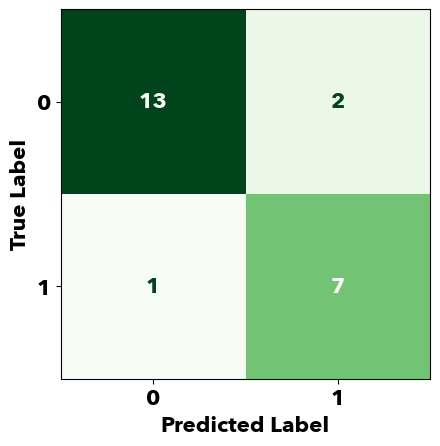

In [20]:
cm_validation = confusion_matrix((virt_lib[validation_output] > user_threshold).astype(int), linear_predictions)

# Display the confusion matrix
disp_validation = ConfusionMatrixDisplay(confusion_matrix=cm_validation)
disp_validation.plot(cmap='Greens', colorbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

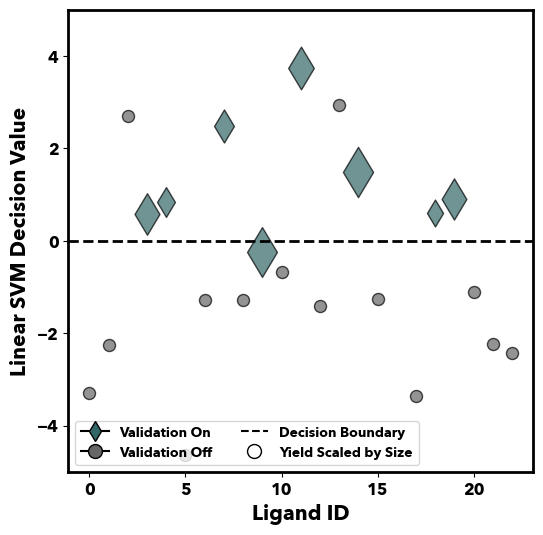

In [21]:
plt.figure(figsize=(6, 6))

# Define a minimum size for the symbols
min_symbol_size = 75
linear_y_min = -5
linear_y_max = 5

# Scatterplot for Linear SVM Data
for idx, row in linear_prediction_df.iterrows():
    marker = 'o' if row['True Class Label'] == 0 else 'd'
    edgecolors = 'black' 
    color = '#666666' if row['True Class Label'] == 0 else '#336666'
    plt.scatter(idx, row['Decision Value'],
                c=color, s=np.maximum(row[output_column] * 9, min_symbol_size),
                marker=marker, edgecolor=edgecolors, alpha=0.7)

plt.xlabel('Ligand ID', fontsize=15)
plt.ylabel('Linear SVM Decision Value', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a dashed line for the decision boundary
plt.axhline(y=0, color='black', linestyle='--', label='Decision Boundary', linewidth=2)

# Set y-axis range
plt.ylim([linear_y_min, linear_y_max])

# Customize the plot borders and ticks
ax = plt.gca()
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.ticklabel_format()
#ax.tick_params(axis='both', width=2)  # Make the ticks thicker

# Add information to the legend
val_legend = plt.Line2D([0], [0], marker='d', color='black', markerfacecolor='#336666', markersize=10, label='Validation On')
val_legend2 = plt.Line2D([0], [0], marker='o', color='black', markerfacecolor='#666666', markersize=10, label='Validation Off')
decision_boundary_legend = plt.Line2D([0], [0], color='black', linestyle='--', label='Decision Boundary')
yield_legend_entry = plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='white', markeredgecolor='black', markersize=10, label='Yield Scaled by Size')

# Uncomment the following line to add the legend
plt.legend(handles=[val_legend, val_legend2, decision_boundary_legend, yield_legend_entry], loc='lower left', ncol=2, fontsize=10)

plt.grid(False)
plt.savefig('linear_validation.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
plt.show()